<h1><center>Ανάλυση Συστημάτων Ηλεκτρικής Ενέργειας - Μόνιμη Κατάσταση Λειτουργίας</center></h1>

<h1><center> ΡΟΗ ΦΟΡΤΙΟΥ</center></h1>

<center><img src="https://i.ibb.co/879pWFg/line-diagram-image.png" alt="line-diagram-image" border="0" /><center>

<h4><center> Σχήμα 1: Σύστημα τεσσάρων ζυγών</center></h4>




Για το σύστημα ηλεκτρικής ενέργειας με την τοπολογία του παραπάνω σχήματος δίνονται τα ακόλουθα δεδομένα:
1. Επαγωγικές αντιδράσεις των γραμμών μεταφοράς: $Z_{AB(1)} =  Z_{AB(2)} = j0,2$ α.μ.,$\quad Z_{CD} = j0,1$ α.μ.,$\quad Z_{DA} = Z_{BC} = j0,2$ α.μ.  

2. Στοιχεία ζυγών:

    * A: Τάση ${V_{A} = 1,0}$ α.μ.
    * B: Παραγωγή ${P_{B} = 0,3}$ α.μ., Tάση $V_{Β} = 1,0$ α.μ
    * C: Φορτίο ${P_{C} = 0,3}$ α.μ.,$\quad{Q_{B} = 0,05}$ α.μ.
    * D: Φορτίο ${P_{D} = 0,4}$ α.μ.,$\quad{Q_{D} = 0,1}$ α.μ.

Εισαγωγή των βιβλιοθηκών της Python που θα χρησιμοποιηθούν:

In [ ]:
import numpy as np
import math
from math import cos, sin
import matplotlib.pyplot as plt
%matplotlib inline

#### Δεδομένα εισόδου
Δεδομένα των ζυγών: 


In [ ]:
def define_bus_data():
    bdataname =['NUM', 'TYPE', 'VOLT', 'DEGREE', 'PLOAD', 'QLOAD','PGER', 'QGER', 'QMIN','QMAX', 'INJMVAR']
    busdata= np.array([[1,   1,  1.00,    0.0,     0,    0,     0,   0,   0,     0,      0],
                       [2,   2,  1.05,    0.0,     0,    0,    30,   0,   0,   500,      0],
                       [3,   0,  1.00,    0.0,    30,    5,     0,   0,   0,   500,      0],
                       [4,   0,  1.00,    0.0,    40,   10,     0,   0,   0,     0,      0]])
    num_bus = busdata.shape[0]
    return busdata, num_bus

busdata, num_bus = define_bus_data()

Δεδομένα των γραμμών μεταφοράς και μετασχηματιστών:


In [ ]:
def define_line_data():
  ldataname= ['NL', 'NR',     'R',     'X', '1/2Bc', 'TAP']
  linedata= np.array([[1,  2,   0.0,   0.1,    0.0,     1],
                      [1,  4,   0.0,   0.2,    0.0,     1],
                      [2,  3,   0.0,   0.2,    0.0,     1],
                      [3,  4,   0.0,   0.1,    0.0,     1]])
  num_lin = linedata.shape[0]
  return linedata, num_lin

linedata, num_lin = define_line_data()

Στο παρακάτω τμήμα κώδικα γίνεται ανάθεση των δεδομένων των ζυγών στις αντίστοιχες μεταβλητές. 
<br>Οι γωνίες μετατρέπονται από μοίρες σε ακτίνια από τη σχέση: $$ (rad)= \frac{\pi}{180^\circ}\cdot δ^\circ \quad (1)$$
<br>Γίνεται το ισοζύγιο ισχύος για κάθε ζυγό $k$ ξεχωριστά και υπολογίζονται οι ανά μονάδα τιμές της έγχυσης ενεργού και αέργου ισχύος από τις σχέσεις:
$$P_{sp,k} = \frac{P_{G,k} -P_{D,k}}{S_{base}}\quad (2)$$
$$Q_{sp,k} = \frac{Q_{G,k} -Q_{D,k}}{S_{base}}\quad (3) $$

In [ ]:
bus_type = [bus[1] for bus in busdata]
Vm = [bus[2] for bus in busdata]
Pd = [bus[4] for bus in busdata]
Qd = [bus[5] for bus in busdata]
Pg = [bus[6] for bus in busdata]
Qg = [bus[7] for bus in busdata]
Qsh = [bus[10] for bus in busdata]

delta = [math.pi/180*bus[3] for bus in busdata]      # (1)
print ('delta=', delta)

basemva = 100
# Initialize Psp, Qsp
Psp = [(bus[6] - bus[4])/basemva for bus in busdata] # (2)
Qsp = [(bus[7] - bus[5])/basemva for bus in busdata] # (3)
print ('Psp=', Psp)
print ('Qsp=', Qsp)



delta= [0.0, 0.0, 0.0, 0.0]
Psp= [0.0, 0.3, -0.3, -0.4]
Qsp= [0.0, 0.0, -0.05, -0.1]


### Υπολογισμός του πίνακα αγωγιμοτήτων του συστήματος

Η συνάρτηση calculation_ybus υπολογίζει τον πίνακα αγωγιμοτήτων του συστήματος.
* Αρχικά όλες οι σύνθετες αντιστάσεις μετατρέπονται σε σύνθετες αγωγιμότητες από τη σχέση $(5)$:
$${Z_{km} = R_{km} + jX_{km}} \quad (4)$$  
$${y_{km} = \frac{1}{Z_{km}}} \quad (5)$$
* και στη συνέχεια υπολογίζονται τα διαγώνια και τα μη διαγώνια στοιχεία του πίνακα αγωγιμοτήτων από τις παρακάάτω σχέσεις.
$$\boxed{Y_{kk}= {y}_{k}+\sum_{m\in A(k)}({y}_{skm}+{y}_{km})\quad (6) \\ Y_{km}=-{y}_{km}\quad (7)}$$
Ο πίνακας αγωγιμοτήτων έχει μέγεθος $(nxn)$ όπου $n$ ο αριθμός των ζυγών του συστήματος που εξετάζουμε.

Στo παράδειγμα αυτόό ο πίνακας αγωγιμοτήτων έχει μέγεθος $(4x4)$.

$$Y_{bus} = \begin{bmatrix} Y_{11} & Y_{12} & Y_{13} & Y_{14}\\ Y_{21} & Y_{22} & Y_{23} & Y_{24}\\ Y_{31} & Y_{32} & Y_{33} & Y_{34}\\ Y_{41} & Y_{42} & Y_{43} & Y_{44} \end{bmatrix}$$ 


In [ ]:
# Function for calculation of admittance matrix
def calculation_ybus(nbus, line_data):
  #Initialize a matrix, nbus x nbus , coplex type
  y_bus = np.zeros([nbus, nbus], dtype=np.complex)

  # Calculation of elements of the lines
  for linedata in line_data:
    p = int(linedata[0]) - 1
    q = int(linedata[1]) - 1
            
    zkm = complex(linedata[2], linedata[3]) # (4)
    bsh = complex(0, linedata[4])
    ykm = 1/zkm                             # (5)
    y_bus[p,p] += ykm + bsh                 # (6)
    if p != q:
      y_bus[q,q] += ykm + bsh               # (6)
      y_bus[p,q] -= ykm                     # (7)
      y_bus[q,p] = y_bus[p,q]

  # Return admittance matrix
  return y_bus

# Admittance matrix
y_bus = calculation_ybus(num_bus, linedata)
print ('Ybus=\n',y_bus)  

Ybus=
 [[0.-15.j 0.+10.j 0. +0.j 0. +5.j]
 [0.+10.j 0.-15.j 0. +5.j 0. +0.j]
 [0. +0.j 0. +5.j 0.-15.j 0.+10.j]
 [0. +5.j 0. +0.j 0.+10.j 0.-15.j]]


Ο πίνακας αγωγιμοτήτων σε καρτεσιανή μορφή γράφεται:
$$Y_{km}=G_{km} +jB_{km} \quad (8)$$

In [ ]:
# Real part of admittance matrix
G = y_bus.real
print ('G=\n',G)    
# Imaginary part of admittance matrix
B = y_bus.imag
print ('B=\n',B)

G=
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
B=
 [[-15.  10.   0.   5.]
 [ 10. -15.   5.   0.]
 [  0.   5. -15.  10.]
 [  5.   0.  10. -15.]]


### Χαρακτηρισμός ζυγών του συστήματος
####  Τύποι ζυγών ροής φορτίου
|   Τύπος ζυγού       |  Γνωστές μεταβλητές  | Άγνωστες μεταβλητές|
|---------------------|----------------------|--------------------|
|Ταλάντωσης ή αναφοράς|$V=1$α.μ.,$δ=0^\circ$ |$P_{G}$,$Q_{G}$     |
|Ζυγoί παραγωγής (PV) |    $P_{G}$,${V}$     |  $Q_{G}$,$δ$       |
|  Ζυγοί φορτίου (PQ) |   $P_{D}$,$Q_{D}$    |$V$, $δ$            |

Στο παράδειγμα είναι:

* **Ζυγός A**: Ζυγός ταλάντωσης (sluck bus). Θεωρούμε ότι η τάση του είναι σταθερή κατά μέτρο και γωνία $V_{1}=1\angle 0^\circ $ α.μ..
* **Ζυγός B**: Ζυγός παραγωγής (PV), αφού είναι γνωστά η παραγόμενη ενεργός ισχύς $P_{B_{G}}=0,3$α.μ. και το μέτρο της τάσης $V_{Β}=1$ α.μ.
* **Ζυγός C**: Ζυγός φορτίου (PQ), αφού είναι γνωστές οι ισχείς φορτίου $P_{C_{D}}=0,3$α.μ., $Q_{C_{D}}=0,05$α.μ.
* **Ζυγός D**: Ζυγός φορτίου (PQ), αφού είναι γνωστές οι ισχείς φορτίου $P_{D_{D}}=0,4$α.μ., $Q_{D_{D}}=0,1$α.μ.

<br>Στον πίνακα των δεδομένων των ζυγών ο ζυγός ταλάντωσης συμβολίζεται με 1, οι ζυγοί PV με 2 και οι ζυγοί PQ με 0.
<br>Στο παρακάτω τμήμα κώδικα η μεταβλητή $nPV$ εμφανίζει το πλήθος των ζυγών PV του προβλήματος, ενώ η μεταβλητή $nPQ$ εμφανίζει το πλήθος των ζυγών PQ. Οι συναρτήσεις sl, pv και pq βρίσκουν το ζυγό ταλάντωσης και τους ζυγούς  PV και PQ αντίστοιχα.


In [ ]:
nPV=0
nPQ=0

for bus in busdata:
    if int(bus[1])==2:
        nPV+=1
    elif int(bus[1])==0:
        nPQ+=1

print ('nPV=',nPV)    
print ('nPQ=',nPQ)        

# Flag for sluck bus
sl = [True if int(bus[1]) == 1 else False for bus in busdata]
print ('sl=',sl)  
# Flag for pv bus      
pv = [True if int(bus[1]) == 2 else False for bus in busdata]
print ('pv=',pv)     
# Flag for pq bus   
pq = [True if int(bus[1]) == 0 else False for bus in busdata]
print ('pq=',pv)


nPV= 1
nPQ= 2
sl= [True, False, False, False]
pv= [False, True, False, False]
pq= [False, True, False, False]


### Δεδομένα και ζητούμενα
#### Το διάνυσμα κατάστασης
Θεωρούμε ότι $n$ είναι ο συνολικός αριθμός των ζυγών του συστήματος και $m$ ο αριθμός των ζυγών φορτίου PQ. Γενικά για $n$ ζυγούς έχουμε $2n$ αγνώστους. Δεδομένου ότι η τάση στο ζυγό ταλάντωσης είναι δεδομένη κατά μέτρο και γωνία, ενώ τα μέτρα των τάσεων είναι γνωστά στους ζυγούς παραγωγής, οι μεταβλητές που πρέπει να προσδιοριστούν για να περιγραφεί πλήρως η κατάσταση λειτουργίας του συστήματος είναι οι ακόλουθες:
* οι φασικές γωνίες τάσεων όλων των ζυγών εκτός από το ζυγό ταλάντωσης 
* τα μέτρα τάσεων όλων των ζυγών φορτίου.

>Οι μεταβλητές αυτές αποτελούν το διάνυσμα κατάστασης $Χ = \begin{bmatrix} δ_2\\...\\δ_n\\V_{n-m+1}\\ ... \\ V_{n} \end{bmatrix} $ με διάσταση $n-1+m$. Άρα για την εύρεση των αγνώστων χρειάζονται $n-1+m$ ανεξάρτητες εξισώσεις.
* $n-1$ εξισώσεις πραγματικής ισχύος (για ζυγούς PV και PQ):
$$\boxed{ΔP_k^{(n)}=P_{sp,k}- V_{k}^{(n)}\cdot \sum_{m\in A(k)}{ V_{m}^{(n)}\cdot[G_{km}\cdot cos(δ_{k}^{(n)} - δ_{m}^{(n)}) + B_{km}\cdot sin( δ_{k}^{(n)} - δ_{m}^{(n)})]}}\quad (9)$$
* $m$ εξισώσεις αέργου ισχύος (για ζυγούς PQ):
$$\boxed{ΔQ_k^{(n)}=Q_{sp,k} - V_{k}^{(n)}\cdot \sum_{m\in A(k)}{ V_{m}^{(n)}\cdot[G_{km}\cdot sin(δ_{k}^{(n)} - δ_{m}^{(n)}) - B_{km}\cdot cos( δ_{k}^{(n)} - δ_{m}^{(n)})]}}\quad (10)$$


Στο παράδειγμα αυτό γνωρίζουμε την τάση του ζυγού A κατά μέτρο και γωνία $V_{A}=1\angle 0^\circ $ α.μ. καθώς και το μέτρο της τάσης του ζυγού B, $V_{B}=1$ α.μ. Επομένως οι άγνωστοι του προβλήματος είναι 5, οι γωνίες $δ_B$, $δ_C$, $δ_D$ και η τάσεις $V_C$, $V_D$.
To διάνυσμα κατάστασης λοιπόν έχει τη μορφή  $Χ = \begin{bmatrix} δ_B\\δ_C\\δ_D\\V_C\\V_D \end{bmatrix} $ και για να υπολογιστεί θα χρειαστούν τρεις εξισώσεις πραγματικής ($ΔP_{Α}$, $ΔP_{B}$, $ΔP_{C}$) και δύο εξισώσεις αέργου ισχύος ($ΔQ_{C}$, $ΔQ_{D}$).

#### Επαναληπτική διαδικασία
* Πριν ξεκινήσουν οι επαναλήψεις της μεθόδου Newton-Raphson θεωρείται μια ενιαία τιμή εκκίνησης για τις τάσεις όλων των ζυγών του δικτύου, που δεν έχουν καθορισμένη τιμή, στα $V=1\angle 0^\circ $ α.μ.
* Χρησιμοποιώντας αυτή την αρχική εκτίμηση υπολογίζεται, με τη βοήθεια των εξισώσεων ροής φορτίου μια βελτιωμένη δεύτερη εκτίμηση η οποία χρησιμοποιείται για να βρεθεί μία τρίτη κ.ο.κ.   
* Οι επαναλήψεις συνεχίζονται μέχρι οι νέες τιμές των μεταβλητών του συστήματος να διαφέρουν από τις αρχικές πολύ λίγο, δηλαδή όταν ικανοποιούνται τα κριτήρια σύγκλισης. $$\boxed{|ΔP_{k}^{(n)}|\leq ε\\ |ΔQ_{k}^{(n)}|\leq ε}\quad (11) $$ 

<br> Στο πρόγραμμα αυτό το κριτήριο είναι: $$|M^{(n)}|\leq ε \quad (12)$$ 
όπου $M$ το διάνυσμα διαφορών: $$Μ  = \begin{bmatrix} ΔP\\ ΔQ \end{bmatrix}\quad (13)$$ και $$ε= 0.001$$ 
<br> H επαναληπτική διαδικασία γίνεται με ένα while loop, το οποίο στην εισοδό του ελέγχει το κριτήριο σύγκλισης της σχέσης $(12)$. Ωστόσο, για να εξηγήσουμε αναλυτικά την 1η επανάληψη, έχουμε χωρίσει τον κώδικα σε τμήματα και έχουμε βάλει τον έλεγχο σε σχόλιο, καθώς για να τρέξει επαναληπτικά πρέπει όλος ο κώδικας που περιέχεται στο while loop να βρίσκεται μέσα στο ίδιο κελί (cell). Στο παρακάτω κομμάτι κώδικα υπολογίζονται οι επαναληπτικές εξισώσεις ροής φορτίου σε όλους τους ζυγούς του ΣΗΕ. Από αυτές χρειαζόμαστε τις τρεις εξισώσεις πραγματικής ισχύος ($ΔP_{Α}$, $ΔP_{B}$, $ΔP_{C}$) , που αποθηκεύονται στο διάνυσμα dP και τις δύο εξίσωση αέργου ισχύος ($ΔQ_{C}$, $ΔQ_{D}$), που αποθηκεύονται στο διάνυσμα dQ. Τα διανύσματα αυτά ενώνονται για να δημιουργηθεί το διάνυσμα διαφορών $Μ$ που έχει ίδιες διαστάσεις με το $Χ$.

In [ ]:
# Initialize dp and dq
dPa = np.zeros([num_bus, 1])
dQa = np.zeros([num_bus, 1])

Tol=1
_iter_=0

# Iteration starting..
#while (Tol >= 0.001 and _iter_<= 10):  # (12)
_iter_+=1

# Initialize Active and Reactive Power 
Pcal = np.zeros([num_bus, 1])
Qcal = np.zeros([num_bus, 1])
    
# Active and reactive power
for k in range(num_bus):
  for m in range(num_bus):
    Pcal[k,0] += Vm[k]*Vm[m]*(G[k,m]*cos(delta[k]-delta[m])+ B[k,m]*sin(delta[k]-delta[m]))  # (9)
    Qcal[k,0] += Vm[k]*Vm[m]*(G[k,m]*sin(delta[k]-delta[m]) - B[k,m]*cos(delta[k]-delta[m])) # (10)
 

# Calculation of dP and dQ
for n in range(num_bus):
  if sl[n]:
    dPa[n] = 0.0
    dQa[n] = 0.0
  else:
    dPa[n] = Psp[n] - Pcal[n, 0] # (9)
    dQa[n] = Qsp[n] - Qcal[n, 0] # (10)
            
k = 0
dQ = np.zeros([nPQ, 1])
for i in range (num_bus):
  if pq[i]==True:
    dQ[k,0] = dQa[i]
    k += 1

dP = dPa[1:]
print ('dP=\n', dP)
print ('dQ=\n', dQ)
        
M = np.vstack([dP, dQ])
print ('M=\n', M)

dP=
 [[ 0.3]
 [-0.3]
 [-0.4]]
dQ=
 [[ 0.2]
 [-0.1]]
M=
 [[ 0.3]
 [-0.3]
 [-0.4]
 [ 0.2]
 [-0.1]]


### 3. Υπολογισμός Ιακωβιανής μήτρας
H Ιακωβιανή μήτρα έχει τη μορφή $$Jac = \begin{bmatrix} H & N\\ J & L \end{bmatrix}\quad (14)$$ 
* O υποπίνακας $Η$ έχει διαστάσεις $(n-1)x(n-1)$
* Ο υποπίνακας $Ν$ έχει διαστάσεις $(n-1)xm$
* Ο υποπίνακας $J$ έχει διαστάσεις $mx(n-1)$
* O υποπίνακας $L$ έχει διαστάσεις $mxm$

Στο παράδειγμα αυτό o υποπίνακας $Η$ έχει διαστάσεις $(3x3)$, ο $Ν\rightarrow(3x2)$, ο $J\rightarrow(2x3)$ και ο $L\rightarrow(2x2)$
  <br>Επομένως η Ιακωβιανή μήτρα έχει τη μορφή: $$Jac = \begin{bmatrix}{H_{22}} & {Η_{23}} & {H_{24}} & {N_{23}} & {N_{24}}\\ {H_{32}} & {H_{33}} & {H_{34}} & {N_{33}} & {N_{34}}\\ {H_{42}} & {H_{43}} & {H_{44}} & {N_{43}} & {N_{44}}\\{J_{32}} & {J_{33}} & {J_{34}} & {L_{33}} & { L_{34}}\\ {J_{42}} & {J_{43}} & {J_{44}} & {L_{43}} & {L_{44}} \end{bmatrix}$$ 

In [ ]:
# Calculation of Jacobian matrix
# Initialization of  submatrixes of Jacobian matrix
H = np.zeros([num_bus-1, num_bus-1])
N = np.zeros([num_bus-1, nPQ])
J = np.zeros([nPQ, num_bus-1])
L = np.zeros([nPQ, nPQ])

Τα διαγώνια και μη διαγώνια στοιχεία του υποπίνακα $Η$ δίνονται από τις σχέσεις:

$$\boxed{H_{kk} =\frac{\partial ΔP_k}{\partial δ_k} = V_{k}^2\cdot Β_{kk}+Q_{k}\quad (15)\\
H_{km}=\frac{\partial ΔP_k}{\partial δ_m} = - V_k\cdot V_m\cdot [G_{km}\cdot sin(δ_{k} - δ_{m}) - B_{km}\cdot cos(δ_{k} - δ_{m})],   k \not= m\quad (16)}$$


In [ ]:
# Calculation of H
for i in range(num_bus-1):
  k=i+1
  for j in range(num_bus-1):
    m=j+1
    for m in range (num_bus):
      if k==m:
        H[k-1, m-1] =  Vm[k]**2*B[k,k]+Qcal[k] # (15)
      elif k!=m:
        H[k-1,m-1] = - Vm[k]*Vm[m]*(G[k,m]*sin(delta[k]-delta[m]) - B[k,m]*cos(delta[k]-delta[m])) # (16)

print ('H=\n',H)        

H=
 [[-15.75   5.25  -0.  ]
 [  5.25 -15.25  10.  ]
 [ -0.    10.   -15.  ]]


Τα διαγώνια και μη διαγώνια στοιχεία του υποπίνακα $N$ δίνονται από τις σχέσεις:

$$\boxed{N_{kk} = \frac{\partial ΔP_k}{\partial V_k}= - V_k \cdot G_{kk}-\frac{P_{k}}{V_{k}}\quad (17)\\
N_{km}=\frac{\partial ΔP_k}{\partial V_m} = - V_k\cdot [G_{km}\cdot cos(δ_{k} - δ_{m}) + B_{km}\cdot sin(δ_{k} - δ_{m})], k \not= m\quad (18)}$$

In [ ]:
# Calculation of N
for i in range(num_bus-1):
  k=i+1
  for j in range (num_bus):
    if pq[j] == True:
      m=j
      for m in range (num_bus):
        if k==m:
          N[k-1, m-nPV-1] = - Vm[k]*G[k, k]-Pcal[k]/Vm[k] # (17)
        elif k!=m:
          N[k-1,m-nPV-1] = -Vm[m]*(G[k,m]*cos(delta[k]-delta[m]) + B[k,m]*sin(delta[k]-delta[m])) # (18)

print ('N=\n', N)          

N=
 [[-0. -0.]
 [-0. -0.]
 [-0. -0.]]


Τα διαγώνια και μη διαγώνια στοιχεία του υποπίνακα $J$ δίνονται από τις σχέσεις:

$$\boxed{J_{kk}=\frac{\partial ΔQ_k}{\partial δ_k} =  V_k^2\cdot G_{kk} -P_{k} \quad (19)\\
J_{km}=\frac{\partial ΔQ_k}{\partial δ_m} =  V_k\cdot V_m\cdot [G_{km}\cdot cos(δ_{k} - δ_{m}) + B_{km}\cdot sin(δ_{k} - δ_{m})], k \not= m\quad (20)}$$

In [ ]:
# Calculation of J
for i in range(num_bus):
  if pq[i] == True:
    k=i    
    for j in range (num_bus-1):
      m=j+1
      if k==m:             
        for m in range (num_bus):
          if k==m:
            J[k-nPV-1, m-1] = Vm[k]**2*G[k, k] - Pcal[k] # (19)
          elif k!=m:
            J[k-nPV-1,m-1] = Vm[k]*Vm[m]*(G[k,m]*cos(delta[k]-delta[m]) + B[k,m] * sin(delta[k]-delta[m])) # (20)

print ('J=\n', J)           

J=
 [[0. 0. 0.]
 [0. 0. 0.]]


Τα διαγώνια και μη διαγώνια στοιχεία του υποπίνακα $L$ δίνονται από τις σχέσεις:

$$\boxed{L_{kk}=\frac{\partial ΔQ_k}{\partial V_m} =  V_k\cdot B_{kk}- \frac{Q_{k}}{V_{k}}\quad (21)\\
L_{km}=\frac{\partial ΔQ_k}{\partial V_m} = - V_k\cdot [G_{km}\cdot sin(δ_{k} - δ_{m}) - B_{km}\cdot cos(δ_{k} - δ_{m})], k \not= m \quad (22)}$$

In [ ]:
# Calculation of L
for i in range(num_bus):
  if pq[i] == True:
    k=i    
    for j in range (num_bus):
      if pq[j] == True:
        m=j    
        if k==m:
          for m in range (num_bus):
            if k==m:
              L[k-nPV-1, m-nPV-1] = Vm[k] * B[k, k] - Qcal[k]/Vm[m] # (21)
            elif k!=m:
              L[k-nPV-1,m-nPV-1] = -Vm[k]*(G[k,m]*sin(delta[k]-delta[m]) - B[k,m]*cos(delta[k]-delta[m])) # (22)

print ('L=\n',L)

L=
 [[-14.75  10.  ]
 [ 10.   -15.  ]]


Επομένως η Ιακωβιανή μήτρα για την 1η επανάληψη θα είναι:

In [ ]:
# Form the Jacobian matrix
JAC = -np.vstack([np.hstack([H, N]), np.hstack([J, L])]) # (14)
print ('JAC=\n', JAC)

JAC=
 [[ 15.75  -5.25   0.     0.     0.  ]
 [ -5.25  15.25 -10.     0.     0.  ]
 [  0.   -10.    15.     0.     0.  ]
 [ -0.    -0.    -0.    14.75 -10.  ]
 [ -0.    -0.    -0.   -10.    15.  ]]


### 4. Υπολογισμός των νέων τάσεων και γωνιών του συστήματος
Από τη γενική εξίσωση Newton-Raphson υπολογίζεται το διάνυσμα των αγνώστων:
$$ Χ = J^{-1}Μ^{(n)}\quad \Rightarrow \quad \begin{bmatrix} Δδ\\ ΔV \end{bmatrix} = \begin{bmatrix} H & N\\ J & L \end{bmatrix}^{-1}\begin{bmatrix} ΔP\\ ΔQ\end{bmatrix} \quad (23)$$

In [ ]:
# Calculation of the inverse Jacobian matrix
INV_JAC = np.linalg.inv(JAC)

# Find the X vector
X = np.dot(INV_JAC, M) # (23)
print('X=\n',X)

dTh = X[:num_bus-1,0]
dV = X[-nPQ:,0]
print ('dTh=\n', dTh)
print ('dV=\n', dV)

X=
 [[-0.00371661]
 [-0.06829268]
 [-0.07219512]
 [ 0.01649485]
 [ 0.0043299 ]]
dTh=
 [-0.00371661 -0.06829268 -0.07219512]
dV=
 [0.01649485 0.0043299 ]


Οι νέες τιμές υπολογίζονται χρησιμοποιώντας τις τιμές της προηγούμενης επανάληψης:

> Indented block


$$\begin{bmatrix}δ\end{bmatrix}^{(n+1)}=\begin{bmatrix}Δδ\end{bmatrix}+\begin{bmatrix} δ\end{bmatrix}^{(n)}\quad (24)$$
$$\begin{bmatrix}V\end{bmatrix}^{(n+1)}=\begin{bmatrix}ΔV\end{bmatrix}+\begin{bmatrix} V\end{bmatrix}^{(n)}\quad (25)$$

Δηλαδή: $$\begin{bmatrix}0\\δ_B\\ δ_C\\ δ_D \end{bmatrix}^{(1)}=\begin{bmatrix}Δδ\end{bmatrix}+ \begin{bmatrix} 0 \\0\\0\\0 \end{bmatrix} $$
και 
$$\begin{bmatrix}1\\1.05\\ V_C\\ V_D \end{bmatrix}^{(1)}=\begin{bmatrix}ΔV\end{bmatrix}+\begin{bmatrix} 1\\1.05\\1\\1 \end{bmatrix}$$

In [ ]:
#Voltage Angle..
delta[1:num_bus] += dTh     # (24)
print ('delta=\n',delta)

#Voltage magnitude
k = 0
for i in range (1,num_bus):
  if pq[i]==True:
    Vm[i] += dV[k]  # (25)
    k += 1

print ('Vm=\n', Vm)

delta=
 [0.0, -0.0037166085946573665, -0.06829268292682926, -0.07219512195121949]
Vm=
 [1.0, 1.05, 1.0164948453608247, 1.0043298969072165]


Μετατροπή γωνιών από ακτίνια σε μοίρες:
$$ δ^\circ= \frac{180^\circ}{\pi}\cdot(rad) \quad (26)$$

In [ ]:
deltad = np.zeros([num_bus, 1])
for n in range(num_bus):
  deltad[n] = (180/math.pi)*delta[n] # (26)

print ('deltad=\n', deltad)

deltad=
 [[ 0.        ]
 [-0.21294599]
 [-3.9128825 ]
 [-4.13647579]]


### 5. Υπολογισμός ισχύων στους ζυγούς 
Οι ισχύς που χρειάζεται να προσδιοριστούν αν πρόκειται:
* Για ζυγό ταλάντωσης, είναι η ενεργός και η άεργος ισχύς του, $P_{G}$,$Q_{G}$  
* Για ζυγο PV, είναι η άεργος ισχύς του, $Q_{G}$
<br>Οι ισχείς αυτές δίνονται από τις σχέσεις:
$$P_G = P_k\cdot S_{base} + P_D \quad (27)$$
$$Q_G = Q_k\cdot S_{base} + Q_D\quad (28)$$
Και οι μιγαδικές ισχείς εκφράζονται ως:
$$S_{k} = P_{k} + jQ_{k}\quad (29)$$

In [ ]:
S = np.zeros([num_bus, 1], dtype=np.complex )
V = np.zeros([num_bus, 1], dtype=np.complex )

for n in range (num_bus):
    if pv[n]==True:
        Qg[n] = Qcal[n]*basemva + Pd[n]   # (28)
        S[n] = complex(Pcal[n], Qcal[n])  # (29)
    elif sl[n]==True:
        Pg[n] = Pcal[n]*basemva + Pd[n]   # (27)
        Qg[n] = Qcal[n]*basemva + Qd[n]   # (28) 
        S[n] = complex(Pcal[n], Qcal[n])  # (29)

for n in range (num_bus):
  V[n] = Vm[n]*complex(cos(delta[n]),sin(delta[n]))

print ('Pg=', Pg)
print ('Qg=', Qg)        

Pg= [array([0.]), 30.0, 0.0, 0.0]
Qg= [array([-50.]), array([78.75]), 0.0, 0.0]


Στο σημείο αυτό ολοκληρώνεται η 1η επανάληψη της μεθόδου. Η μεταβλητή $Τol$ παίρνει την τιμή της μέγιστης απόλυτης τιμής του διανύσματος διαφορών $Μ$ ώστε να ελεγχθεί το κριτήριο σύγκλισης στην αρχή του while loop.    
Το παρακάάτω τμήμα κώδικα εμφανίζει τα τελικά αποτελέσματα της ροής φορτίου.

In [ ]:
Pgt = np.zeros([num_bus, 1])
Qgt = np.zeros([num_bus, 1])
Pdt = np.zeros([num_bus, 1])
Qdt = np.zeros([num_bus, 1])
Qsht = np.zeros([num_bus,1])

Pgt= sum(Pg)
Qgt= sum(Qg)
Pdt= sum(Pd)
Qdt= sum(Qd)
Qsht= sum(Qsh)

#  This program prints the power flow solution in a tabulated form on the screen.
print('          Power Flow Solution by Newton-Raphson Method')
print('               Maximum Power Mismatch = ', Tol)
print('                    No. of Iterations = ', _iter_, '\n') 

print ('Bus      Voltage Angle ------Load------ ---Generation--- Injected')
print ('No.      Mag.    Degree  MW       Mvar   MW       Mvar   Mvar    ')
print( '                                                      ')

for n  in range (num_bus):
    print(n+1,'\t',"%.3f"%Vm[n],'\t',"%.2f"%deltad[n],'\t',"%.2f"%Pd[n],'\t',"%.2f"%Qd[n],
          '\t',"%.2f"%Pg[n],'\t',"%.2f"%Qg[n],'\t',"%.2f"%Qsh[n])

print('      \n')
print('    Total               ', "%.2f"%Pdt,'\t',"%.2f"%Qdt,'\t',"%.2f"%Pgt,'\t',"%.2f"%Qgt,'\t',"%.2f"%Qsht)

# Tolerance..
#Tol= abs(max(M, key=abs))

          Power Flow Solution by Newton-Raphson Method
               Maximum Power Mismatch =  1
                    No. of Iterations =  1 

Bus      Voltage Angle ------Load------ ---Generation--- Injected
No.      Mag.    Degree  MW       Mvar   MW       Mvar   Mvar    
                                                      
1 	 1.000 	 0.00 	 0.00 	 0.00 	 0.00 	 -50.00 	 0.00
2 	 1.050 	 -0.21 	 0.00 	 0.00 	 30.00 	 78.75 	 0.00
3 	 1.016 	 -3.91 	 30.00 	 5.00 	 0.00 	 0.00 	 0.00
4 	 1.004 	 -4.14 	 40.00 	 10.00 	 0.00 	 0.00 	 0.00
      

    Total                70.00 	 15.00 	 30.00 	 28.75 	 0.00


Το παρακάτω κελί περιέχει όλο τον κώδικα της ροής φορτίου με τη μέθοδο Νewton-Raphson που περιγράψαμε αναλυτικά παραπάνω, το οποίο τρέχει και εμφανίζει τα αποτελέσματα για τις τρεις πρώτες επαναλήψεις όπου και συγκλίνει. 

In [ ]:
busdata, num_bus = define_bus_data() 
linedata, num_lin = define_line_data()
 
bus_type = [bus[1] for bus in busdata]
Vm = [bus[2] for bus in busdata]
Pd = [bus[4] for bus in busdata]
Qd = [bus[5] for bus in busdata]
Pg = [bus[6] for bus in busdata]
Qg = [bus[7] for bus in busdata]
Qsh = [bus[10] for bus in busdata]

delta = [math.pi/180*bus[3] for bus in busdata]      # (1)

basemva = 100
# Initialize Psp, Qsp
Psp = [(bus[6] - bus[4])/basemva for bus in busdata] # (2)
Qsp = [(bus[7] - bus[5])/basemva for bus in busdata] # (3)

# Admittance matrix
y_bus = calculation_ybus(num_bus, linedata)

# Real part of admittance matrix
G = y_bus.real  
# Imaginary part of admittance matrix
B = y_bus.imag

nPV=0
nPQ=0

for bus in busdata:
    if int(bus[1])==2:
        nPV+=1
    elif int(bus[1])==0:
        nPQ+=1      

# Flag for sluck bus
sl = [True if int(bus[1]) == 1 else False for bus in busdata] 
# Flag for pv bus      
pv = [True if int(bus[1]) == 2 else False for bus in busdata]
# Flag for pq bus   
pq = [True if int(bus[1]) == 0 else False for bus in busdata]

# Initialize dp and dq
dPa = np.zeros([num_bus, 1])
dQa = np.zeros([num_bus, 1])


Vbus = [bus[2] for bus in busdata]
Pgbus = [bus[6] for bus in busdata]
Qgbus = [bus[7] for bus in busdata]

Tol=1
_iter_=0

# Iteration starting..
while (Tol >= 0.001 and _iter_<= 10):  # (12)
  _iter_+=1
  # Initialize Active and Reactive Power 
  Pcal = np.zeros([num_bus, 1])
  Qcal = np.zeros([num_bus, 1])
    
  # Active and reactive power
  for k in range(num_bus):
    for m in range(num_bus):
      Pcal[k,0] += Vm[k]*Vm[m]*(G[k,m]*cos(delta[k]-delta[m])+ B[k,m]*sin(delta[k]-delta[m]))  # (9)
      Qcal[k,0] += Vm[k]*Vm[m]*(G[k,m]*sin(delta[k]-delta[m]) - B[k,m]*cos(delta[k]-delta[m])) # (10)
           
  # Calculation of dP and dQ
  for nbus in range(num_bus):
    if sl[nbus]:
      dPa[nbus] = 0.0
      dQa[nbus] = 0.0
    else:
      dPa[nbus] = Psp[nbus] - Pcal[nbus, 0]
      dQa[nbus] = Qsp[nbus] - Qcal[nbus, 0]
                  
  k = 0
  dQ = np.zeros([nPQ, 1])
  for i in range (num_bus):
    if pq[i]==True:
      dQ[k,0] = dQa[i]
      k += 1

  dP = dPa[1:]
        
  M = np.vstack([dP, dQ])

  # Calculation of Jacobian matrix

  # Initialization of  submatrixes of Jacobian matrix
  H = np.zeros([num_bus-1, num_bus-1])
  N = np.zeros([num_bus-1, nPQ])
  J = np.zeros([nPQ, num_bus-1])
  L = np.zeros([nPQ, nPQ])

  # Calculation of H
  for i in range(num_bus-1):
    k=i+1
    for j in range(num_bus-1):
      m=j+1
      for m in range (num_bus):
        if k==m:
          H[k-1, m-1] = Vm[k]**2*B[k,k]+Qcal[k] # (15)
        elif k!=m:
          H[k-1,m-1] = - Vm[k]*Vm[m]*(G[k,m] * sin(delta[k]-delta[m]) - B[k,m] * cos(delta[k]-delta[m])) # (16)
                    
  # Calculation of N
  for i in range(num_bus-1):
    k=i+1
    for j in range (num_bus):
      if pq[j] == True:
        m=j
        for m in range (num_bus):
          if k==m:
            N[k-1, m-nPV-1] = - Vm[k]*G[k, k]-Pcal[k]/Vm[k] # (17)
          elif k!=m:
            N[k-1,m-nPV-1] = -Vm[m]*(G[k,m]*cos(delta[k]-delta[m]) + B[k,m]*sin(delta[k]-delta[m])) # (18)
                                        
  # Calculation of J
  for i in range(num_bus):
    if pq[i] == True:
      k=i    
      for j in range (num_bus-1):
        m=j+1
        if k==m:
          for m in range (num_bus):
            if k==m:
              J[k-nPV-1, m-1] = Vm[k]**2*G[k, k] - Pcal[k] # (19)
            elif k!=m:
              J[k-nPV-1,m-1] = Vm[k]*Vm[m]*(G[k,m]*cos(delta[k]-delta[m]) + B[k,m] * sin(delta[k]-delta[m])) # (20)

  # Calculation of L
  for i in range(num_bus):
    if pq[i] == True:
      k=i    
      for j in range (num_bus):
        if pq[j] == True:
          m=j    
          if k==m:
            for m in range (num_bus):
              if k==m:
                L[k-nPV-1, m-nPV-1] = Vm[k] * B[k, k] - Qcal[k]/Vm[m] # (21)
              elif k!=m:
                L[k-nPV-1,m-nPV-1] = -Vm[k]*(G[k,m]*sin(delta[k]-delta[m]) - B[k,m]*cos(delta[k]-delta[m])) #(22)

                  
  # Form the Jacobian matrix
  JAC = -np.vstack([np.hstack([H, N]), np.hstack([J, L])]) # (14)

  # Calculation of the inverse Jacobian matrix
  INV_JAC = np.linalg.inv(JAC)  

  # Find the X vector
  X = np.dot(INV_JAC, M) # (23)

  dTh = X[:num_bus-1,0]
  dV = X[-nPQ:,0]
  
  #Voltage Angle..
  delta[1:num_bus] += dTh # (24)
  
  #Voltage magnitude
  k = 0
  for i in range (1,num_bus):
    if pq[i]==True:
      Vm[i] += dV[k]     # (25)
      k += 1

  deltad = np.zeros([num_bus, 1])
  for nbus in range(num_bus):
    deltad[nbus] = (180/math.pi)*delta[nbus] # (26)

  S = np.zeros([num_bus, 1], dtype=np.complex )

  for n in range (num_bus):
    if pv[n]==True:
      Qg[n] = Qcal[n]*basemva + Pd[n]   # (28)
      S[n] = complex(Pcal[n], Qcal[n])  # (29)
    elif sl[n]==True:
      Pg[n] = Pcal[n]*basemva + Pd[n]   # (27)
      Qg[n] = Qcal[n]*basemva + Qd[n]   # (28) 
      S[n] = complex(Pcal[n], Qcal[n])  # (29)  

  for n in range (num_bus):
    V[n] = Vm[n]*complex(cos(delta[n]),sin(delta[n]))   
  
  Vbus = np.vstack([Vm,Vbus])
  Pgbus = np.vstack([Pg,Pgbus])
  Qgbus = np.vstack([Qg,Qgbus])

  busdata[:,2]  = Vm
  busdata[:,3] = np.transpose(deltad) 

  Pgt = np.zeros([num_bus, 1])
  Qgt = np.zeros([num_bus, 1])
  Pdt = np.zeros([num_bus, 1])
  Qdt = np.zeros([num_bus, 1])
  Qsht = np.zeros([num_bus, 1])

  Pgt= sum(Pg)
  Qgt= sum(Qg)
  Pdt= sum(Pd)
  Qdt= sum(Qd)
  Qsht= sum(Qsh)

  #  This program prints the power flow solution in a tabulated form on the screen.
  print('          Power Flow Solution by Newton-Raphson Method')
  print('               Maximum Power Mismatch = ', Tol)
  print('                    No. of Iterations = ', _iter_, '\n') 

  print ('Bus      Voltage Angle ------Load------ ---Generation--- Injected')
  print ('No.      Mag.    Degree  MW       Mvar   MW       Mvar   Mvar    ')
  print( '                                                      ')

  for n  in range (num_bus):
    print(n+1,'\t',"%.3f"%Vm[n],'\t',"%.2f"%deltad[n],'\t',"%.2f"%Pd[n],'\t',"%.2f"%Qd[n],
          '\t',"%.2f"%Pg[n],'\t',"%.2f"%Qg[n],'\t',"%.2f"%Qsh[n])

  print('      \n')
  print('    Total               ', "%.2f"%Pdt,'\t',"%.2f"%Qdt,'\t',"%.2f"%Pgt,'\t',"%.2f"%Qgt,'\t',"%.2f"%Qsht,'\n')
    
  Tol= abs(max(M, key=abs)) 

          Power Flow Solution by Newton-Raphson Method
               Maximum Power Mismatch =  1
                    No. of Iterations =  1 

Bus      Voltage Angle ------Load------ ---Generation--- Injected
No.      Mag.    Degree  MW       Mvar   MW       Mvar   Mvar    
                                                      
1 	 1.000 	 0.00 	 0.00 	 0.00 	 0.00 	 -50.00 	 0.00
2 	 1.050 	 -0.21 	 0.00 	 0.00 	 30.00 	 78.75 	 0.00
3 	 1.016 	 -3.91 	 30.00 	 5.00 	 0.00 	 0.00 	 0.00
4 	 1.004 	 -4.14 	 40.00 	 10.00 	 0.00 	 0.00 	 0.00
      

    Total                70.00 	 15.00 	 30.00 	 28.75 	 0.00 

          Power Flow Solution by Newton-Raphson Method
               Maximum Power Mismatch =  [0.4]
                    No. of Iterations =  2 

Bus      Voltage Angle ------Load------ ---Generation--- Injected
No.      Mag.    Degree  MW       Mvar   MW       Mvar   Mvar    
                                                      
1 	 1.000 	 0.00 	 0.00 	 0.00 	 40.12 	 -50.8

In [ ]:
Iter = np.arange(_iter_+1)
Vbus=np.flipud(Vbus)
Pgbus=np.flipud(Pgbus)
Qgbus = np.flipud(Qgbus)

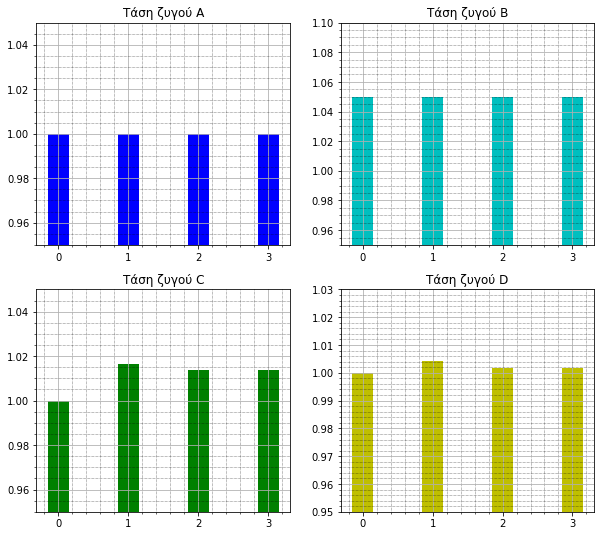

In [ ]:
y_pos = np.arange(len(Iter))
f = plt.figure(figsize=(10,9))

N = ['A','B','C','D']
L = [1.05, 1.1, 1.05, 1.03]
C = ['b','c','g','y'] # Cell array of colors.
for k in range (num_bus):
    plt.subplot(2, 2, k+1)
    plt.bar(y_pos,Vbus[:,k], 0.3, color=C[k])
    plt.xticks(y_pos, Iter)
    plt.ylim(0.95, L[k])
    plt.title('Τάση ζυγού '+ N[k])
    plt.grid()
    plt.minorticks_on()
    plt.grid(which='minor',linestyle=':', linewidth='0.5', color='black')
plt.show()

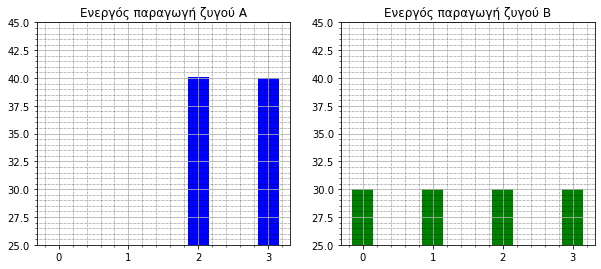

In [ ]:
f = plt.figure(figsize=(10,9))
N = ['A','B']
C = ['b','g'] # Cell array of colors.
for k in range (num_bus-2):
    plt.subplot(2, 2, k+1)
    plt.bar(y_pos, Pgbus[:,k], 0.3, color=C[k])
    plt.xticks(y_pos, Iter)
    plt.ylim(25, 45)
    plt.title('Ενεργός παραγωγή ζυγού '+ N[k])
    plt.grid()
    plt.minorticks_on()
    plt.grid(which='minor',linestyle=':', linewidth='0.5', color='black')
plt.show()

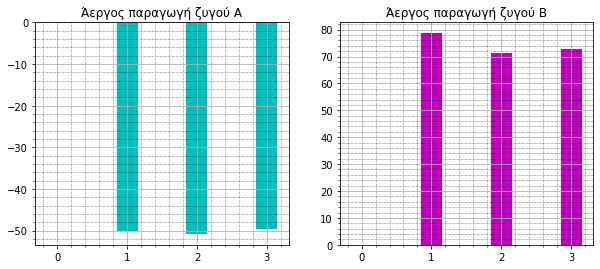

In [ ]:
f = plt.figure(figsize=(10,9))
N = ['A','B']
C = ['c','m'] # Cell array of colors.
for k in range (num_bus-2):
    plt.subplot(2, 2, k+1)
    plt.bar(y_pos, Qgbus[:,k], 0.3, color=C[k])
    plt.xticks(y_pos, Iter)
    #plt.ylim(25, 45)
    plt.title('Άεργος παραγωγή ζυγού '+ N[k])
    plt.grid()
    plt.minorticks_on()
    plt.grid(which='minor',linestyle=':', linewidth='0.5', color='black')
plt.show()